In [1]:
%matplotlib inline
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import ulmo

plt.rcParams['figure.figsize'] = [10, 8]

df=gpd.read_file('/glade/u/home/currierw/work/shape/crb/b9522000.shp')
df.crs = {'init':'epsg:4269'} # based on readme file
df=df.to_crs(epsg=4326)

# Import state vector file using geopandas
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

In [2]:
#http://his.cuahsi.org/wofws.html
wsdlurl = 'http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'
#wsdlurl = "http://worldwater.byu.edu/interactive/snotel/services/index.php/cuahsi_1_1.asmx?WSDL"  # WOF 1.1
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [3]:
sites_df=pd.DataFrame.from_dict(sites,orient='index')
sites_df=sites_df.dropna()
sites_df['geometry'] = [Point(float(loc['longitude']), float(loc['latitude'])) for loc in sites_df['location']]
sites_df = sites_df.drop(columns='location')
sites_df = sites_df.astype({"elevation_m":float})
sites_gdf = gpd.GeoDataFrame(sites_df, geometry='geometry')
sites_gdf.crs = {'init':'epsg:4326'}

# "clip" a points layer to the boundary of a polygon
poly = df.geometry.unary_union
sites_gdf_crb = sites_gdf[sites_gdf.geometry.intersects(poly)]
sites_gdf_crb = sites_gdf_crb.assign(siteStr=sites_gdf_crb.index.str[:])


Text(0.5, 1, 'SNOTEL Sites within a Buffer 1° of the CRB Domain')

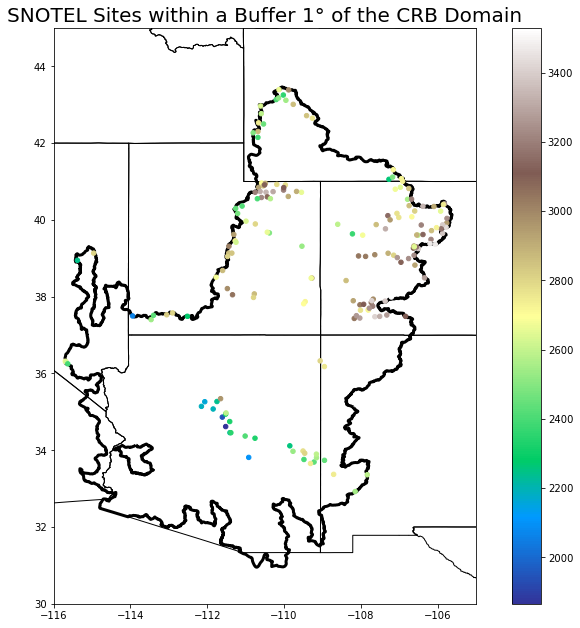

In [4]:
ax = plt.axes((0,0,1,1))
states_gdf.plot(facecolor='none', edgecolor='black',ax=ax)
df.plot(ax=ax,facecolor='none', edgecolor='black',linewidth=3)
sites_gdf_crb.plot(ax=ax,column='elevation_m',markersize=20,cmap='terrain',legend=True)
ax.set_xlim(-116,-105)
ax.set_ylim(30,45)
ax.set_title('SNOTEL Sites within a Buffer 1° of the CRB Domain',fontsize=20)

In [5]:
idx=sites_gdf_crb['elevation_m'].idxmax() # Identify the highest site in domain
site_info = ulmo.cuahsi.wof.get_site_info(wsdlurl, idx) # Query the server for information about this site
site_info['series'].keys() # Inspect the returned information

dict_keys(['SNOTEL:BATT_D', 'SNOTEL:BATT_H', 'SNOTEL:BATX_H', 'SNOTEL:PRCP_y', 'SNOTEL:PRCP_sm', 'SNOTEL:PRCP_m', 'SNOTEL:PRCP_wy', 'SNOTEL:PRCPSA_y', 'SNOTEL:PRCPSA_D', 'SNOTEL:PRCPSA_sm', 'SNOTEL:PRCPSA_m', 'SNOTEL:PRCPSA_wy', 'SNOTEL:PREC_sm', 'SNOTEL:PREC_m', 'SNOTEL:SNWD_D', 'SNOTEL:SNWD_sm', 'SNOTEL:SNWD_H', 'SNOTEL:SNWD_m', 'SNOTEL:TAVG_y', 'SNOTEL:TAVG_D', 'SNOTEL:TAVG_sm', 'SNOTEL:TAVG_m', 'SNOTEL:TAVG_wy', 'SNOTEL:TMAX_y', 'SNOTEL:TMAX_D', 'SNOTEL:TMAX_sm', 'SNOTEL:TMAX_m', 'SNOTEL:TMAX_wy', 'SNOTEL:TMIN_y', 'SNOTEL:TMIN_D', 'SNOTEL:TMIN_sm', 'SNOTEL:TMIN_m', 'SNOTEL:TMIN_wy', 'SNOTEL:TOBS_D', 'SNOTEL:TOBS_sm', 'SNOTEL:TOBS_H', 'SNOTEL:TOBS_m', 'SNOTEL:WTEQ_D', 'SNOTEL:WTEQ_sm', 'SNOTEL:WTEQ_H', 'SNOTEL:WTEQ_m'])

In [6]:
variablecode = 'SNOTEL:WTEQ_D'
ulmo.cuahsi.wof.get_variable_info(wsdlurl, variablecode)

{'value_type': 'Field Observation',
 'data_type': 'Continuous',
 'general_category': 'Soil',
 'sample_medium': 'Snow',
 'no_data_value': '-9999',
 'speciation': 'Not Applicable',
 'code': 'WTEQ_D',
 'id': '310',
 'name': 'Snow water equivalent',
 'vocabulary': 'SNOTEL',
 'time': {'is_regular': True,
  'interval': '1',
  'units': {'abbreviation': 'd',
   'code': '104',
   'name': 'day',
   'type': 'Time'}},
 'units': {'abbreviation': 'in',
  'code': '49',
  'name': 'international inch',
  'type': 'Length'}}

In [7]:
# Get current datetime
variablecode = 'SNOTEL:WTEQ_D'
ulmo.cuahsi.wof.get_variable_info(wsdlurl, variablecode)

today = datetime.today().strftime('%Y-%m-%d')
start_date='1950-10-01'
end_date=today

def fetch(sitecode, variablecode='SNOTEL:SNWD_D', start_date='1950-10-01', end_date=today):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=end_date)
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True)
        #Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)

    return values_df

In [8]:
pkl_fn = 'snotel_crb_WTEQ_D_d_20200305.pkl'

In [9]:
if os.path.exists(pkl_fn):
    crb_dict = pd.read_pickle(pkl_fn)
else:
    #Define an empty dictionary to store returns for each site
    value_dict = {}
    for i, sitecode in enumerate(sites_gdf_crb.index):
        print('%i of %i sites' % (i+1, len(sites_gdf_crb.index)) )
        out = fetch(sitecode, variablecode, start_date, end_date)
        if out is not None:
            value_dict[sitecode] = out['value']
    #Convert the dictionary to a DataFrame, automatically handles different datetime ranges (nice!)
    crb_dict = pd.DataFrame.from_dict(value_dict)
    #Write out
    crb_dict.to_pickle(pkl_fn)

In [10]:
crb_dict

,SNOTEL:1030_CO_SNTL,SNOTEL:308_AZ_SNTL,SNOTEL:1140_AZ_SNTL,SNOTEL:310_AZ_SNTL,SNOTEL:1212_AZ_SNTL,SNOTEL:317_WY_SNTL,SNOTEL:1061_CO_SNTL,SNOTEL:1041_CO_SNTL,SNOTEL:902_AZ_SNTL,SNOTEL:1143_AZ_SNTL,...,SNOTEL:849_NV_SNTL,SNOTEL:853_UT_SNTL,SNOTEL:1160_CO_SNTL,SNOTEL:859_WY_SNTL,SNOTEL:861_AZ_SNTL,SNOTEL:864_UT_SNTL,SNOTEL:866_AZ_SNTL,SNOTEL:869_CO_SNTL,SNOTEL:877_AZ_SNTL,SNOTEL:1228_UT_SNTL
datetime,,,,,,,,,,,,,,,,,,,,,
1978-10-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
1978-10-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
1978-10-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
1978-10-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
1978-10-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-01 00:00:00+00:00,18.8,1.0,11.0,7.1,0.0,12.6,10.6,11.2,0.1,8.5,...,6.2,13.8,14.8,29.1,0.3,8.9,0.0,11.2,0.0,9.2
2020-03-02 00:00:00+00:00,19.2,0.7,11.0,6.7,0.0,12.6,10.6,11.4,0.1,8.5,...,6.2,13.8,14.8,29.5,0.3,9.0,0.0,11.2,0.0,9.2
2020-03-03 00:00:00+00:00,19.2,0.6,10.9,6.7,0.1,12.5,10.5,11.4,0.1,8.4,...,6.1,13.9,14.8,29.7,0.2,9.0,0.1,11.2,0.0,9.2
